In [ ]:
import pandas as pd
import json
import matplotlib.pyplot as plt

In [2]:
## select cancer types
cancer_types = ['THYM', 'DLBC', 'SKCM', 'TGCT', 'LUAD', 'MESO', 'LUSC']

In [3]:
## read processed data
data = pd.read_csv('./data/processed_data.tsv', sep='\t')

## load gene lists
with open('../genes.json', 'r') as f:
    marker_genes = json.load(f)

## remove pd1
for key in marker_genes:
    marker_genes[key] = [gene for gene in marker_genes[key] if gene != 'PDCD1']

## recalculate overall score
for marker in marker_genes:
    data[marker] = data[marker_genes[marker]].mean(axis=1)

data['overall_score_no_pd1'] = data[list(marker_genes.keys())].mean(axis=1)

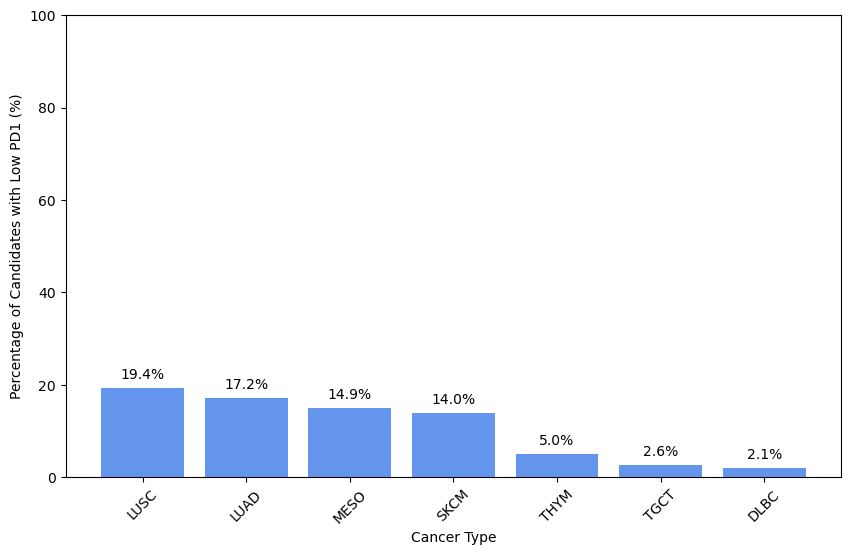

In [4]:
# Filter for top 7 cancer types
filtered_data = data[data['project_id'].isin(cancer_types)]

# Find percentiles for overall score and PD1
overall_80th = data['overall_score_no_pd1'].quantile(0.8)
pd1_80th = data['PDCD1'].quantile(0.8)

# Count number in each category
total_counts = []
overall_counts = []
overall_and_pd1_counts = []

for cancer_type in cancer_types:
    subset = filtered_data[filtered_data['project_id'] == cancer_type]
    
    # Count for number of patients in each cancer type
    total_count = subset.shape[0]
    
    # Count for overall score >= 80th percentile
    overall_count = subset.loc[subset['overall_score_no_pd1'] >= overall_80th].shape[0]

    # Count for both overall score >= 80th percentile and PD1 >= 80th percentile
    overall_and_pd1_count = subset.loc[(subset['overall_score_no_pd1'] >= overall_80th) & 
                                       (subset['PDCD1'] >= pd1_80th)].shape[0]
    
    total_counts.append(total_count)
    overall_counts.append(overall_count)
    overall_and_pd1_counts.append(overall_and_pd1_count)
    
only_overall_counts = [overall_counts[i] - overall_and_pd1_counts[i] for i in range(len(cancer_types))]

# Compute percentage of total patients
percentage_only_overall = [(only_overall_counts[i] / total_counts[i]) * 100 for i in range(len(cancer_types))]

# Sort cancer types by decreasing percentage
sorted_indices = sorted(range(len(percentage_only_overall)), key=lambda i: percentage_only_overall[i], reverse=True)
sorted_cancer_types = [cancer_types[i] for i in sorted_indices]
sorted_percentages = [percentage_only_overall[i] for i in sorted_indices]

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(sorted_cancer_types, sorted_percentages, color='cornflowerblue')

# Add labels and title
plt.xlabel('Cancer Type')
plt.ylabel('Percentage of Candidates with Low PD1 (%)')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.ylim(0, 100)  # Stretch y-axis to 100%

# Add percentage labels on top of bars
for i, v in enumerate(sorted_percentages):
    plt.text(i, v + 2, f'{v:.1f}%', ha='center', fontsize=10)  # Adjust label position

# Show the plot
plt.savefig('./figures/figure_3.png')
plt.show()